# Gaussian Noise

In [1]:
import os
import sys

# Add the parent directory (lfi) to sys.path
sys.path.insert(0, os.path.abspath('..'))
import sbi
import sbi.utils
import sbi.inference
import sbi.diagnostics
import sbi.analysis
import lfi
import torch
import numpy as np

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
2024-12-05 13:36:45.125 | INFO     | lfi.config:<module>:11 - PROJ_ROOT path is: /home/givasile/github/projects/sbi


## SBI - Rejection Sampling 

In [96]:
D = 10
sim = lfi.simulators.GaussianNoise(sigma_noise=0.1)
prior = lfi.priors.UniformPrior(low=-2, high=2, dim=D)
observation = np.random.uniform(-2, 2, size=D)
prior_sbi = prior.sbi_uniform()

In [97]:
observation

array([ 1.44234924,  1.69618309,  1.39120612,  0.82516768, -1.38699958,
       -1.7526114 ,  0.21313843,  0.41619114,  0.63716156, -1.8807431 ])

In [19]:
mcabc = sbi.inference.MCABC(simulator=sim.sample_pytorch, prior=prior.sbi_uniform())
theta_posterior = mcabc(x_o=observation, num_simulations=100_000, quantile=0.01)

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

In [20]:
theta_posterior

tensor([[-0.8401,  0.1468, -0.6266,  0.1231, -1.2887],
        [-0.4961,  0.2955, -0.3499,  0.1209, -1.3155],
        [-0.4707,  0.1455, -0.2786, -0.0516, -1.3340],
        ...,
        [ 0.1055,  0.6850, -0.3301, -0.5486, -0.9737],
        [ 0.0191,  0.8745, -1.1033,  0.1013, -1.3972],
        [-1.0999,  0.2241, -1.3061,  0.6712, -0.9401]])

### Diagnostics

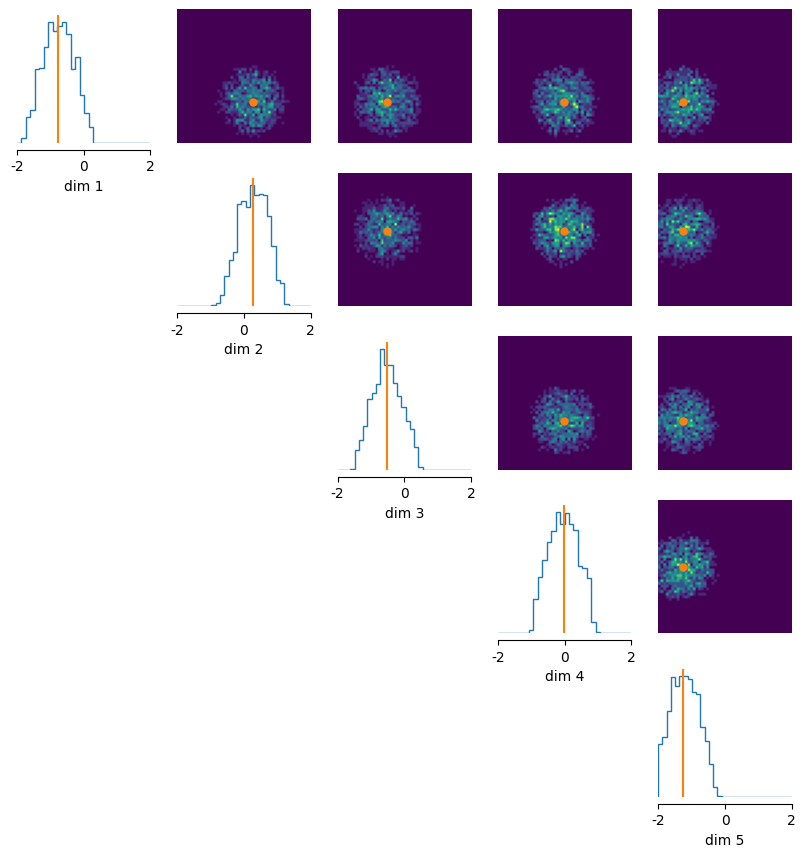

In [27]:
fig, ax = sbi.analysis.pairplot(theta_posterior, limits=torch.tensor([-2, 2.]).repeat(D, 1), points=observation)

In [28]:
## NPE

In [155]:
D = 50
sim = lfi.simulators.GaussianNoise(sigma_noise=0.1)
prior = lfi.priors.UniformPrior(low=-2, high=2, dim=D)
observation = np.random.uniform(-2, 2, size=D)
prior_sbi = prior.sbi_uniform()

In [156]:
observation

array([-1.30009938,  1.19152384, -0.34066172, -0.3542889 , -0.66314159,
        0.79185239, -1.01382062,  1.06222483, -1.78943454, -0.69357892,
       -0.88676813,  1.88228554, -0.46423667,  0.69189799, -1.08183657,
        0.1204853 ,  0.63560008,  1.33902798,  1.40186424, -1.68396796,
       -1.90961341,  1.6042091 , -1.03269048,  1.71958358,  1.22400624,
        0.93398517, -0.77964138, -1.22210546, -0.35009539,  1.80780957,
        0.39789646, -1.33863698,  0.3944399 ,  1.93759151,  0.45121081,
       -0.73551315, -1.9605278 ,  0.41048805, -0.51329507, -0.49430459,
        0.18524178, -1.24385304, -0.57168025, -0.41175681, -1.47735887,
        0.82391388, -0.91235587,  0.68176942, -1.57826173,  1.33274331])

In [157]:
fmpe = sbi.inference.FMPE(prior=prior_sbi)

In [158]:
N = 10_000
thetas = prior.sbi_uniform().sample_n(N)
x_0 = sim.sample_pytorch(thetas)

/tmp/ipykernel_3264/2029274617.py:2: FutureWarning: `sample_n(n)` will be deprecated. Use `sample((n,))` instead.
  thetas = prior.sbi_uniform().sample_n(N)


In [159]:
x_0

tensor([[ 0.8805,  0.7638, -0.8898,  ..., -1.2778, -1.3511, -1.3300],
        [-1.8645, -1.5924, -0.3534,  ..., -1.4465, -1.5379,  1.7826],
        [ 1.5642, -1.2964, -0.4426,  ..., -1.9356,  1.1585, -1.2471],
        ...,
        [-0.2449, -0.7451,  0.6938,  ..., -0.5103,  0.2978,  0.5889],
        [-1.6226,  0.4394, -1.1092,  ..., -0.0540,  0.8412, -0.4749],
        [-1.0011, -0.1029, -0.4801,  ..., -1.7755, -0.6071, -0.8262]])

In [160]:
fmpe.append_simulations(theta=thetas, x=x_0)

In [161]:
fmpe.train()

 Neural network successfully converged after 253 epochs.

FlowMatchingEstimator(
  (net): VectorFieldMLP(
    (net): MLP(
      (0): Linear(in_features=106, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ELU(alpha=1.0)
      (8): Linear(in_features=64, out_features=64, bias=True)
      (9): ELU(alpha=1.0)
      (10): Linear(in_features=64, out_features=50, bias=True)
    )
  )
  (_embedding_net): Sequential(
    (0): Standardize()
    (1): Identity()
  )
)

In [162]:
posterior = fmpe.build_posterior(x_0=observation)

In [163]:
theta_posterior_1 = posterior.sample((1000,), x=observation)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    -3 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


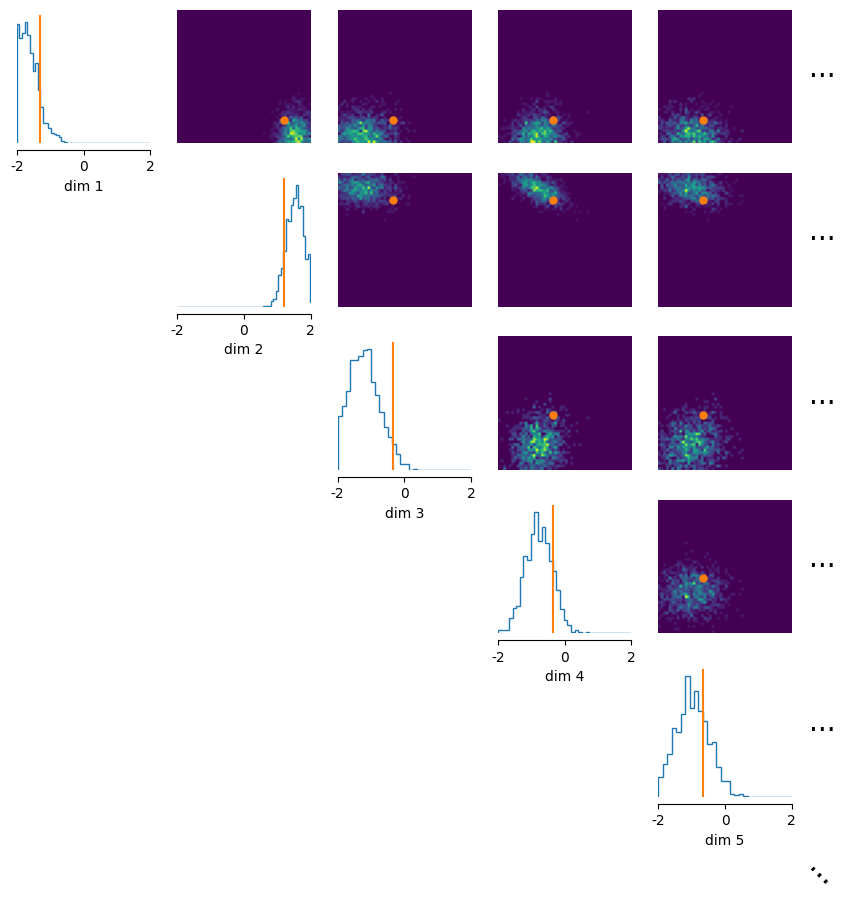

In [164]:
fig, ax = sbi.analysis.pairplot(theta_posterior_1, limits=torch.tensor([-2, 2.]).repeat(D, 1), points=observation, subset=[i for i in range(5)])